<a href="https://colab.research.google.com/github/kweteM/loan-approval-prediction/blob/main/Loan_Approval_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from imblearn.pipeline import Pipeline as imbalanced_Pipeline

In [ ]:
# Load the dataset
df = pd.read_csv('/content/loan_approval.csv')

In [ ]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [ ]:
df['Loan_Status'].value_counts()

Loan_Status
Y    422
N    192
Name: count, dtype: int64

In [ ]:
# Handle missing values
df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].median(), inplace=True)
df['Credit_History'].fillna(df['Credit_History'].median(), inplace=True)
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['Married'].fillna(df['Married'].mode()[0], inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)

In [ ]:
# Drop non-numeric columns (e.g., Loan_ID) if they are not useful for prediction
df = df.drop(columns=['Loan_ID'])

In [ ]:
# Convert categorical features to numeric using Label Encoding
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
for feature in categorical_features:
    if df[feature].dtype == 'object':
        le = LabelEncoder()
        df[feature] = le.fit_transform(df[feature])

In [ ]:
# Separate features and target variable
X = df.drop(columns=['Loan_Status'])
y = df['Loan_Status'].map({'Y': 1, 'N': 0})  # Convert target variable to numeric (1 for Approved, 0 for Not Approved)

In [ ]:
# Scale numerical features
scaler = StandardScaler()
numerical_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
X[numerical_features] = scaler.fit_transform(X[numerical_features])

In [ ]:
y.value_counts() # Checking the imbalanced data

Loan_Status
1    422
0    192
Name: count, dtype: int64

In [ ]:
# Handle the imbalanced data
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

y_sm.value_counts()

Loan_Status
1    422
0    422
Name: count, dtype: int64

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42, stratify=y_sm)

In [ ]:
# Define and evaluate models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

In [ ]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probability scores for the positive class

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    results[name] = {
        'Accuracy': accuracy,
        'Confusion Matrix': conf_matrix,
        'Classification Report': class_report,
        'y_prob': y_prob
    }

In [ ]:
# Identify the best model (based on accuracy, for example)
best_model_name = max(results, key=lambda name: results[name]['Accuracy'])
best_model = models[best_model_name]
best_y_prob = results[best_model_name]['y_prob']

In [ ]:
# Plot performance of the best model
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Approved', 'Approved'],
                yticklabels=['Not Approved', 'Approved'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

In [ ]:
def plot_roc_curve(y_test, y_prob, model_name):
    from sklearn.metrics import roc_curve, roc_auc_score
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.show()

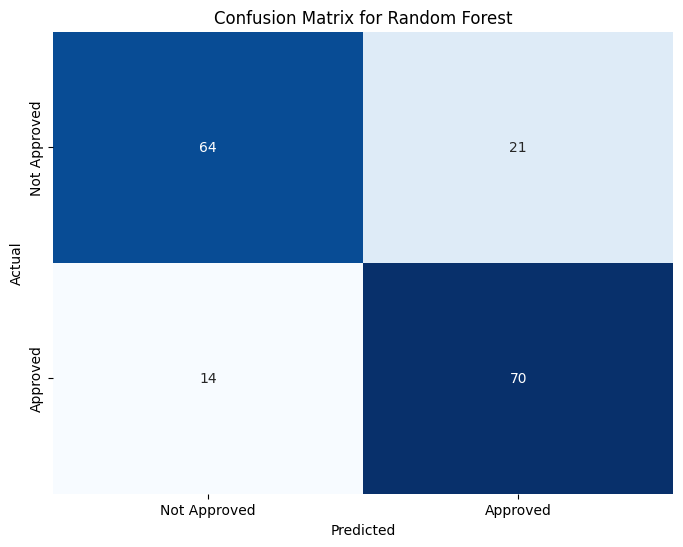

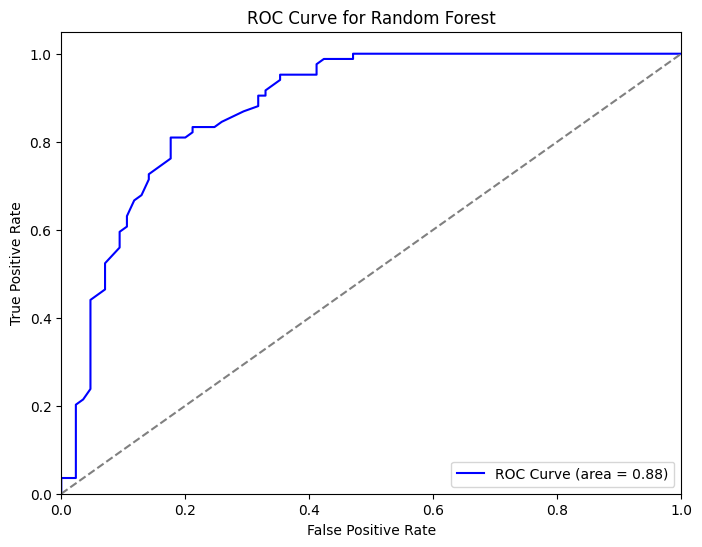

In [ ]:
# Plot results for the best model
best_cm = results[best_model_name]['Confusion Matrix']
plot_confusion_matrix(best_cm, best_model_name)

best_y_prob = results[best_model_name]['y_prob']
plot_roc_curve(y_test, best_y_prob, best_model_name)

In [ ]:
# Print classification report for the best model
print(f"Classification Report for {best_model_name}:\n")
print(results[best_model_name]['Classification Report'])

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.82      0.75      0.79        85
           1       0.77      0.83      0.80        84

    accuracy                           0.79       169
   macro avg       0.79      0.79      0.79       169
weighted avg       0.80      0.79      0.79       169

